In [1]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

raw_df = pd.read_csv("data/raw_data.csv")
raw_df = raw_df[["Name","Zweck"]]
raw_df.drop_duplicates(inplace=True)
raw_df.fillna('',inplace=True)
raw_df.head(3)

,Name,Zweck
0,,"Nord-Süd-Tangente; Linie 26/27, 2.2. Teil-BPU,A"
1,Berolina-Orchester e. V. Berliner Symphoniker,Gedenken zu 30 Jahre Mauerfall
2,Camino Werkstatt für Fortbildung Praxisbegleitung und Forschung gGmbH,Lernen Na Logo - Bildungsnetzwerk Hellersdorfer Promenade


In [2]:
df = raw_df.copy()

df = df.apply(lambda row: row["Name"]+" "+row["Zweck"], axis=1)
df.head(3)

0                                                                                    Nord-Süd-Tangente; Linie 26/27, 2.2. Teil-BPU,A
1                                                       Berolina-Orchester e. V. Berliner Symphoniker Gedenken zu 30 Jahre Mauerfall
2    Camino Werkstatt für Fortbildung Praxisbegleitung und Forschung gGmbH Lernen Na Logo - Bildungsnetzwerk Hellersdorfer Promenade
dtype: object

### Elbow method using bert sentence embeddings

In [3]:
import torch
from transformers import BertModel, BertTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from lib.bert_pytorch.helper_functions import get_device

class BertSentenceEmbeddigs(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
        self.device = get_device()
        self.model = BertModel.from_pretrained('bert-base-german-cased', 
                                                output_hidden_states=True)\
                                                    .to(self.device)
        self.model.eval()
    def embed_sentence(self, sentence: str):
        ids_tensor = self.tokenizer.encode(sentence, return_tensors='pt')
        ids_tensor = ids_tensor.to(self.device)
        with torch.no_grad():
            out = self.model(input_ids=ids_tensor)
        hidden_states = out.hidden_states
        last_four_layers = [hidden_states[i] for i in (-1, -2, -3, -4)]
        sentence_embedding = torch.cat(tuple(last_four_layers), dim=0)
        sentence_embedding = torch.mean(sentence_embedding, dim=0)
        sentence_embedding = torch.mean(sentence_embedding, dim=0)
        return sentence_embedding.cpu().numpy()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.apply(self.embed_sentence)
        X = pd.DataFrame(X.values.tolist())
        return X

bse = BertSentenceEmbeddigs()
df_bert = bse.fit_transform(df.copy())
df_bert.head(3)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2070 with Max-Q Design


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.680419,0.433664,0.439248,0.866302,-0.352283,0.405156,0.042996,0.474451,-0.042971,-0.087204,...,0.303186,-0.299498,0.331566,0.211172,0.274229,0.532789,-0.644731,0.511696,0.032847,0.031498
1,0.362836,-0.278531,-0.221352,0.162534,-0.275386,0.042783,-0.072428,0.566699,-0.337875,0.091432,...,-0.601389,-0.034728,0.073473,0.033858,-0.111781,-0.016581,-0.136314,0.486694,0.190122,0.207916
2,0.152593,-0.161159,-0.049797,0.220832,-0.516910,0.164789,-0.047174,0.591982,-0.229227,-0.111129,...,-0.288481,0.024140,0.593051,-0.115749,0.063671,0.176311,-0.261437,0.346691,0.235066,-0.136431


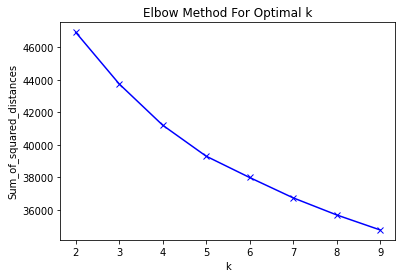

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(df_bert)
   Sum_of_squared_distances.append(km.inertia_)

   
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Elbow method using tf-idf vectors

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import spacy


class CleanText(BaseEstimator, TransformerMixin):
    def cleaner(self, text):
        # Remove mid slash and digits
        text = re.sub(r'-', ' ', text)
        text = re.sub(r'\d+', '', text)
        # Custom ones not supported by spacy
        text = re.sub(r'Abs\.', 'Absatz', text)
        text = re.sub(r'e\.V\.', 'eingetragener Verein', text)
        text = re.sub(r'co\.', 'Kompanie', text)
        text = re.sub(r'Co\.', 'Kompanie', text)
        text = re.sub(r'gem\.', 'gemäß', text)
        text = re.sub(r"'s", '', text)
        return text
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.apply(self.cleaner)
        return X

class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = spacy.load("de_core_news_lg")
        self.nlp.remove_pipe("ner")
        self.nlp.remove_pipe("parser")
        self.nlp.remove_pipe("attribute_ruler")
    def normalize(self, text):
        doc = self.nlp(text)
        output = []
        for token in doc:
            if not token.is_punct and not token.is_stop and not token.is_space:
                output.append(token.lemma_)
        return " ".join(output)
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.apply(self.normalize)
        return X

class Lowercase(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.apply(lambda text: text.lower())
        return X

class TfIdfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self
    def transform(self, X, y=None):
        tfidf_encodings = self.vectorizer.transform(X)
        X = pd.DataFrame(tfidf_encodings.toarray())
        return X


prep_pipeline = Pipeline([
    ("clean_text", CleanText()),
    ("spacy_lemmatizer", SpacyLemmatizer()),
    ("text_lowercase", Lowercase()),
    ("tfidf_vectorizer", TfIdfVectorizer()),
])


df_tfidf = prep_pipeline.fit_transform(df.copy())

df_tfidf.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2326,2327,2328,2329,2330,2331,2332,2333,2334,2335
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


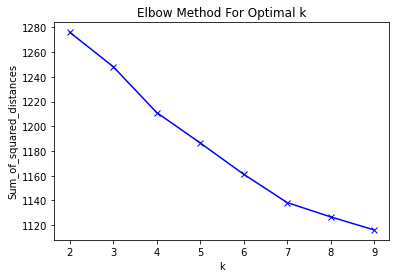

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=100, n_init=20, random_state=42)
   km = km.fit(df_tfidf)
   Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### KMeans with k=7 and tfidf as vectorizer

In [7]:
model = KMeans(n_clusters=7, max_iter=100, n_init=20, random_state=42)
model.fit(df_tfidf)

prep_pipeline_short = Pipeline([
    ("clean_text", CleanText()),
    ("spacy_lemmatizer", SpacyLemmatizer()),
    ("text_lowercase", Lowercase()),
])

df = prep_pipeline_short.transform(df.copy())
df = df.to_frame()
df["pred_cluster"] = model.labels_
df.groupby("pred_cluster").count()

,0
pred_cluster,
0,190
1,43
2,104
3,63
4,746
5,100
6,120


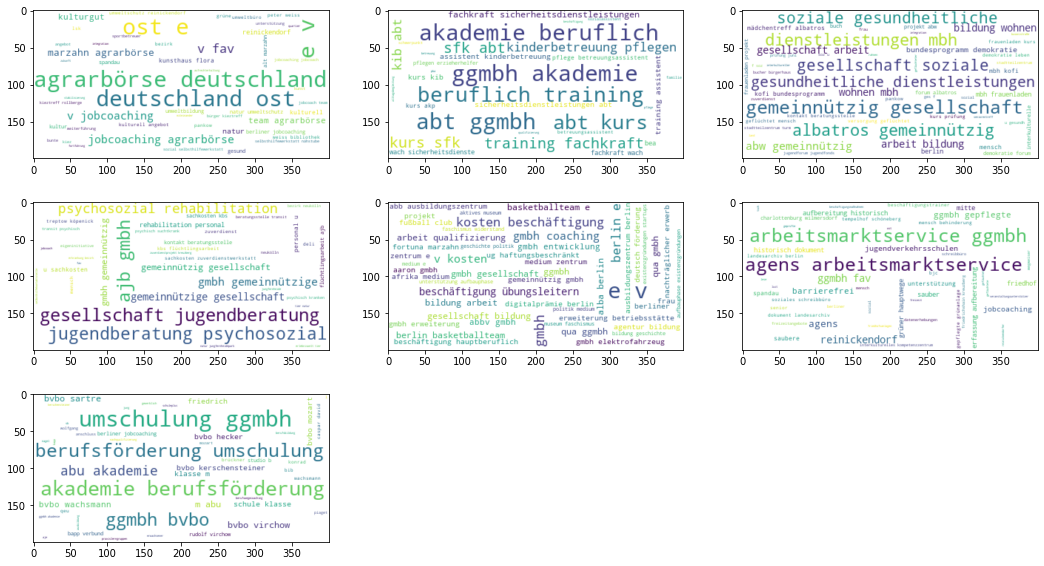

In [8]:
from wordcloud import WordCloud

plt.figure(figsize=(18,10))
for i in df["pred_cluster"].unique():
    plt.subplot(3,3,i+1)
    text = df[df["pred_cluster"]==i][0].str.cat(sep=' ')
    wordcloud = WordCloud(max_font_size=30, max_words=50, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")

plt.show()